In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
from notebooks.visualization.activations_funcs import (
    get_activation_dictionnary,
    load_neuron_position_data,
)


import networkx as nx
import seaborn as sns

from paths import PROJECT_ROOT
plots_dir = os.path.join(PROJECT_ROOT, "plots")

NUM_PASSES = 3

sns.set_theme(style="whitegrid", font_scale=1.4)

# Set up the figure with Nature-compatible settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Arial', 'Helvetica', 'sans-serif']
plt.rcParams["font.size"] = 16
plt.rcParams["axes.linewidth"] = 0.5
plt.rcParams["xtick.major.width"] = 0.5
plt.rcParams["ytick.major.width"] = 0.5

Changed working directory to /home/eudald/Escriptori/doctorat/connectome
Project root: /home/eudald/Escriptori/doctorat/connectome


In [2]:
configurations = get_activation_dictionnary(NUM_PASSES)
neuron_position_data = load_neuron_position_data()

# Panel A

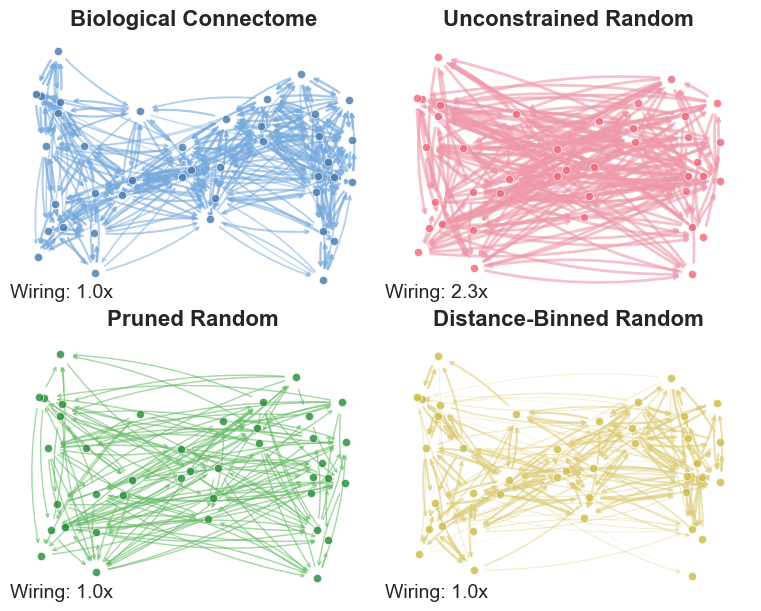

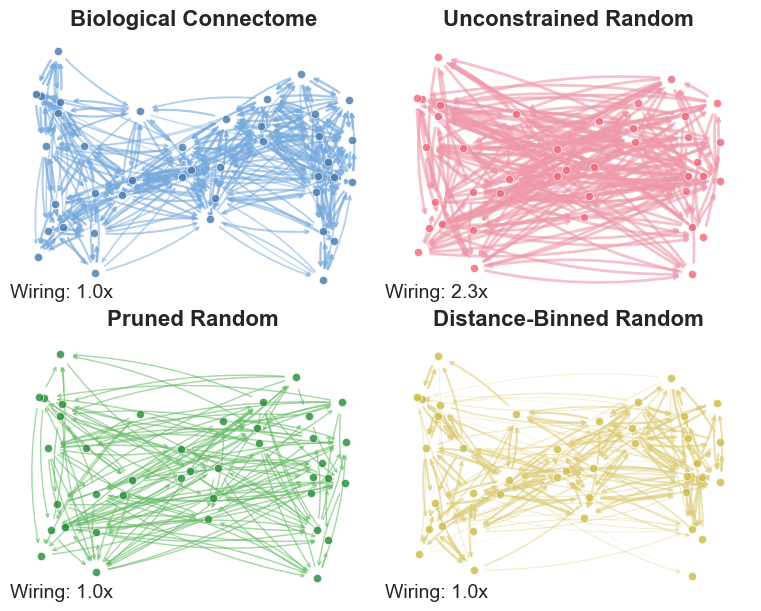

In [9]:
def panel_a():
    # Create figure
    fig1, axs = plt.subplots(2, 2, figsize=(7.5, 6), constrained_layout=True)
    axs = axs.flatten()

    # Set a seed for reproducibility
    np.random.seed(42)

    # Generate 3D coordinates for neurons - fixed to exactly n_nodes
    n_nodes = 40
    nodes_2d = np.zeros((n_nodes, 2))

    # Create clusters of nodes
    cluster_centers = [
        [0, 0],  # center
        [-1.5, 1],  # top left
        [1.5, 1],  # top right
        [-1.5, -1],  # bottom left
        [1.5, -1],  # bottom right
    ]

    # Assign nodes to clusters with jitter
    nodes_per_cluster = n_nodes // len(cluster_centers)
    for i, center in enumerate(cluster_centers):
        start_idx = i * nodes_per_cluster
        end_idx = start_idx + nodes_per_cluster if i < len(cluster_centers) - 1 else n_nodes

        for j in range(start_idx, end_idx):
            # Add position with random jitter
            nodes_2d[j, 0] = center[0] + np.random.normal(0, 0.5)
            nodes_2d[j, 1] = center[1] + np.random.normal(0, 0.5)

    # Create fake 3D positions (only needed for distance calculations)
    nodes_3d = np.column_stack((nodes_2d, np.zeros(n_nodes)))

    # Transform 3D to 2D coordinates for visualization
    nodes_2d = nodes_3d[:, :2]

    # Create a distance matrix
    dist_matrix = np.zeros((n_nodes, n_nodes))
    for i in range(n_nodes):
        for j in range(n_nodes):
            dist_matrix[i, j] = np.sqrt(np.sum((nodes_3d[i] - nodes_3d[j]) ** 2))

    # Normalize distances
    max_dist = np.max(dist_matrix)
    norm_dist_matrix = dist_matrix / max_dist

    # Define edge densities and colors with explicit wiring lengths
    configs = [
        {
            "title": "Biological Connectome",
            "density": 0.1,
            "node_color": "#4477AA",
            "edge_color": "#77AADD",
            "rel_length": 1.0,
            "prefers_short": True,
        },
        {
            "title": "Unconstrained Random",
            "density": 0.15,
            "node_color": "#EE6677",
            "edge_color": "#EE99AA",
            "rel_length": 2.3,
            "prefers_short": False,
        },
        {
            "title": "Pruned Random",
            "density": 0.1,
            "node_color": "#228833",
            "edge_color": "#66BB66",
            "rel_length": 1.0,
            "prefers_short": False,
        },
        {
            "title": "Distance-Binned Random",
            "density": 0.1,
            "node_color": "#CCBB44",
            "edge_color": "#DDCC77",
            "rel_length": 1.0,
            "prefers_short": True,
        },
    ]

    # Generate the graphs for each configuration
    for idx, config in enumerate(configs):
        # Create a new graph
        G = nx.DiGraph()

        # Add nodes
        for i in range(n_nodes):
            G.add_node(i, pos=nodes_2d[i])

        # Create edges based on configuration
        edges_to_add = []

        if config["title"] == "Biological Connectome":
            # Much stronger preference for short connections
            distance_threshold = 0.6  # Only allow connections below this normalized distance
            
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i != j and norm_dist_matrix[i, j] < distance_threshold:
                        # Higher probability for shorter connections
                        p_connect = (1 - norm_dist_matrix[i, j]/distance_threshold)**2 * config["density"] * 15
                        if np.random.random() < p_connect:
                            weight = 1.0  # Consistent weight
                            edges_to_add.append((i, j, {'weight': weight, 'distance': dist_matrix[i, j]}))
        
        elif config["title"] == "Unconstrained Random":
            # Random connections regardless of distance
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i != j and np.random.random() < config["density"]:
                        weight = np.random.uniform(0.5, 1)
                        edges_to_add.append(
                            (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                        )

        elif config["title"] == "Pruned Random":
            # Random connections regardless of distance
            for i in range(n_nodes):
                for j in range(n_nodes):
                    if i != j and np.random.random() < config["density"]:
                        weight = np.random.uniform(0.2, 0.7)
                        edges_to_add.append(
                            (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                        )

        elif config["title"] == "Distance-Binned Random":
            # Divide distances into bins and randomize within each bin
            dist_bins = [
                0,
                0.3,
                0.6,
                1.0,
            ]  # Three distance bins with emphasis on shorter connections
            bin_densities = [0.3, 0.1, 0.05]  # Higher density for shorter connections

            for bin_idx in range(len(dist_bins) - 1):
                bin_min, bin_max = dist_bins[bin_idx], dist_bins[bin_idx + 1]
                bin_density = bin_densities[bin_idx]

                # Find node pairs in this distance bin
                bin_pairs = []
                for i in range(n_nodes):
                    for j in range(n_nodes):
                        if i != j and bin_min <= norm_dist_matrix[i, j] < bin_max:
                            bin_pairs.append((i, j))

                # Randomly select pairs from this bin
                np.random.shuffle(bin_pairs)
                bin_edges_count = int(len(bin_pairs) * bin_density)

                for i, j in bin_pairs[:bin_edges_count]:
                    weight = np.random.uniform(0.5, 1.0)
                    edges_to_add.append(
                        (i, j, {"weight": weight, "distance": dist_matrix[i, j]})
                    )

        # Add the edges to the graph
        for u, v, data in edges_to_add:
            G.add_edge(u, v, **data)

        # Get positions and draw
        pos = nx.get_node_attributes(G, "pos")

        # Calculate node sizes based on degree
        node_sizes = [20 + 3 * G.degree(n) for n in G.nodes()]
       
        # Draw the nodes
        nx.draw_networkx_nodes(
            G,
            pos,
            ax=axs[idx],
            node_size=35,
            node_color=config["node_color"],
            alpha=0.8,
            edgecolors="white",
            linewidths=0.5,
        )

        # Draw edges with color and width encoding distance
        # Short connections: thicker and more opaque
        # Long connections: thinner and more transparent
        for u, v, data in G.edges(data=True):
            distance = data["distance"] / max_dist

            # Determine edge properties based on distance
            if config["prefers_short"]:
                # For configurations that prefer short connections
                width = max(0.5, 2.0 * (1.0 - distance))
                alpha = max(0.2, 0.8 * (1.0 - distance))
            else:
                # For configurations that don't differentiate by distance
                width = 1.0
                alpha = 0.6

            nx.draw_networkx_edges(
                G,
                pos,
                ax=axs[idx],
                edgelist=[(u, v)],
                width=width * 2 if config["title"] == "Unconstrained Random" else width,
                alpha=alpha,
                edge_color=config["edge_color"],
                arrows=True,
                arrowsize=6,
                arrowstyle="->",
                connectionstyle="arc3,rad=0.1",
            )

        # Add title and wiring info
        axs[idx].set_title(config["title"], fontsize=16, fontweight="bold")
        axs[idx].text(
            0.,
            0.,
            f"Wiring: {config['rel_length']:.1f}x",
            transform=axs[idx].transAxes,
            fontsize=14,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )

        # Remove axes
        axs[idx].set_xticks([])
        axs[idx].set_yticks([])
        axs[idx].spines["top"].set_visible(False)
        axs[idx].spines["right"].set_visible(False)
        axs[idx].spines["bottom"].set_visible(False)
        axs[idx].spines["left"].set_visible(False)

        # plt.suptitle("Network Configuration Comparison", fontsize=10, fontweight="bold")
        plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.png"), dpi=300, bbox_inches="tight")
        plt.savefig(os.path.join(plots_dir, "figure2a_network_configs.pdf"), bbox_inches="tight")


    return fig1

panel_a()

# Panel b

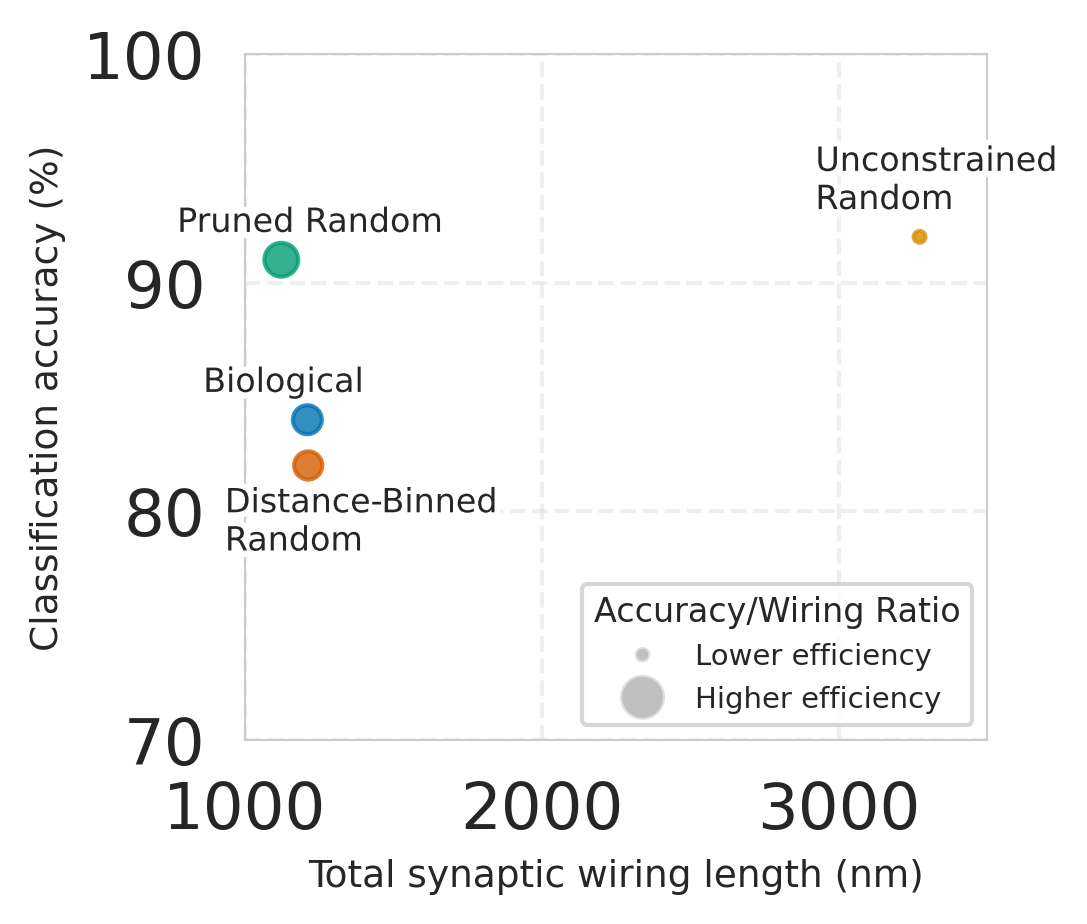

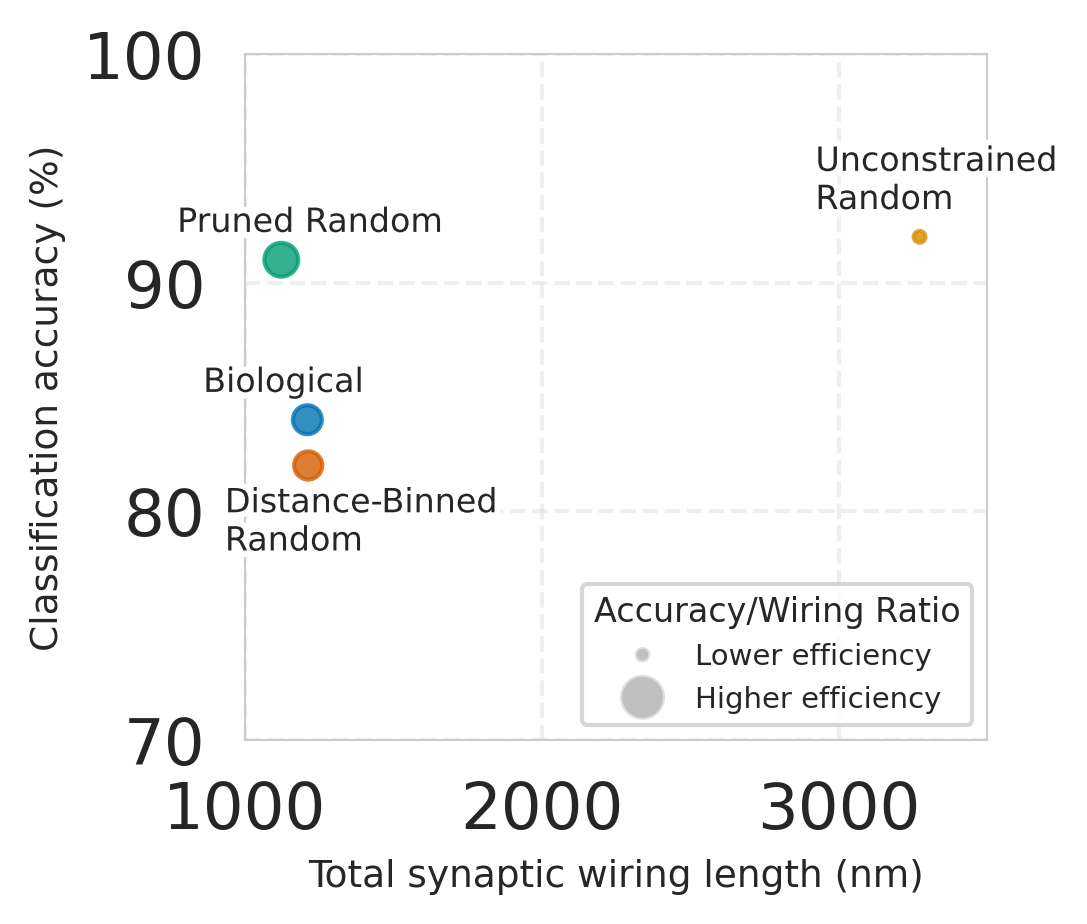

In [4]:
from utils.shuffle_connections import compute_total_synapse_length
import pandas as pd

def panel_b(neuron_position_data):
    networks = [
        "Biological",
        "Unconstrained\nRandom",
        "Pruned Random",
        "Distance-Binned\nRandom",
    ]

    connections_original = pd.read_csv(
        os.path.join(PROJECT_ROOT, "new_data", "connections.csv"),
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    connections_unconstrained = pd.read_csv(
        os.path.join(PROJECT_ROOT, "new_data", "connections_random_unconstrained.csv"),
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    connections_pruned = pd.read_csv(
        os.path.join(PROJECT_ROOT, "new_data", "connections_random_pruned.csv"),
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )
    connections_binned = pd.read_csv(
        os.path.join(PROJECT_ROOT, "new_data", "connections_random_binned.csv"),
        dtype={
            "pre_root_id": "string",
            "post_root_id": "string",
            "syn_count": np.int32,
        },
    )

    # Rename pos_x, pos_y, pos_z to soma_x, soma_y, soma_z
    neuron_position_data = neuron_position_data.rename(columns={"pos_x": "soma_x", "pos_y": "soma_y", "pos_z": "soma_z"})
    
    # Compute wiring lenghts for each network
    original_length = compute_total_synapse_length(connections_original, neuron_position_data)
    unconstrained_length = compute_total_synapse_length(connections_unconstrained, neuron_position_data)
    pruned_length = compute_total_synapse_length(connections_pruned, neuron_position_data)
    binned_length = compute_total_synapse_length(connections_binned, neuron_position_data)
    
    # Total synaptic length (mm)
    wiring_length = [a / 1e9 for a in [original_length, unconstrained_length, pruned_length, binned_length]]  
    # Mean accuracy (%) (from the sheets)
    accuracy = [84, 92, 91, 82] 

    # Calculate efficiency (accuracy per unit wiring)
    efficiency = [acc / length * 100 for acc, length in zip(accuracy, wiring_length)]

    # Colors that work well for Nature (colorblind-friendly, print-friendly)
    colors = ["#0173B2", "#DE8F05", "#029E73", "#D55E00"]

    # Create the figure with Nature-compatible dimensions
    fig2, ax = plt.subplots(figsize=(3.5, 3.2), dpi=300)  # Nature's single column width

    # Create scatter plot with varying point sizes based on efficiency
    sizes = [e ** 2 for e in efficiency]  # Scale efficiency for better visualization
    scatter = ax.scatter(wiring_length, accuracy, s=sizes, c=colors, alpha=0.8, zorder=3)

    """# Connect points with a line to show the trade-off
    # Only connect biological to unconstrained random to show the main comparison
    ax.plot(
        [wiring_length[0], wiring_length[1]],
        [accuracy[0], accuracy[1]],
        "k--",
        alpha=0.3,
        zorder=1,
    )"""

    # Add labels with a white outline for better visibility
    for i, txt in enumerate(networks):
        if txt == "Distance-Binned\nRandom":
            va = "top" 
            x_offset = -20
            y_offset = -5 
        else:
            va = "bottom"
            x_offset = -25
            y_offset = 5
            
        text = ax.annotate(
            txt,
            (wiring_length[i], accuracy[i]),
            fontsize=8,
            ha="left",
            va=va,
            xytext=(x_offset, y_offset),
            textcoords="offset points",
        )
        text.set_path_effects([PathEffects.withStroke(linewidth=3, foreground="white")])

    # Add x and y-axis labels with units
    ax.set_xlabel("Total synaptic wiring length (nm)", fontsize=9)
    ax.set_ylabel("Classification accuracy (%)", fontsize=9)

    # Set axis limits with some padding
    ax.set_xlim(1000, 3500)
    ax.set_ylim(70, 100)

    # Add grid for readability (light grid typical for Nature figures)
    ax.grid(linestyle="--", alpha=0.3, zorder=0)


    # Create legend for the point sizes representing efficiency
    # Create custom handles for legend
    class SizedPatchHandler(HandlerPatch):
        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)

        def create_artists(
            self, legend, orig_handle, xdescent, ydescent, width, height, fontsize, trans
        ):
            size = orig_handle.get_width()
            p = mpatches.Circle(
                (0.5 * width - 0.5 * xdescent, 0.5 * height - 0.5 * ydescent),
                size / 3,
                edgecolor=orig_handle.get_edgecolor(),
                facecolor=orig_handle.get_facecolor(),
                transform=trans,
            )
            return [p]


    # Create legend handles
    efficiency_levels = [min(efficiency), max(efficiency)]
    legend_sizes = [e * 2 for e in efficiency_levels]
    legend_labels = [f"{e:.1f}" for e in efficiency_levels]

    handles = [
        mpatches.Rectangle(
            (0, 0), legend_sizes[0], legend_sizes[0], facecolor="gray", alpha=0.5
        ),
        mpatches.Rectangle(
            (0, 0), legend_sizes[1], legend_sizes[1], facecolor="gray", alpha=0.5
        ),
    ]

    # Add legend with custom handler
    ax.legend(
        handles,
        [f"Lower efficiency", f"Higher efficiency"],
        title="Accuracy/Wiring Ratio",
        handler_map={mpatches.Rectangle: SizedPatchHandler()},
        loc="lower right",
        fontsize=7,
        title_fontsize=8,
    )

    # Adjust layout and save
    plt.tight_layout()
    fig2.subplots_adjust(right=0.98, top=0.95)

    # Save figure with transparent background (Nature preference)
    plt.savefig(os.path.join(plots_dir,"figure2_panel_b.png"), dpi=300, bbox_inches="tight", transparent=True)
    plt.savefig(os.path.join(plots_dir,"figure2_panel_b.pdf"), bbox_inches="tight") 
    #plt.show()

    return fig2

panel_b(neuron_position_data)

# Pancel c

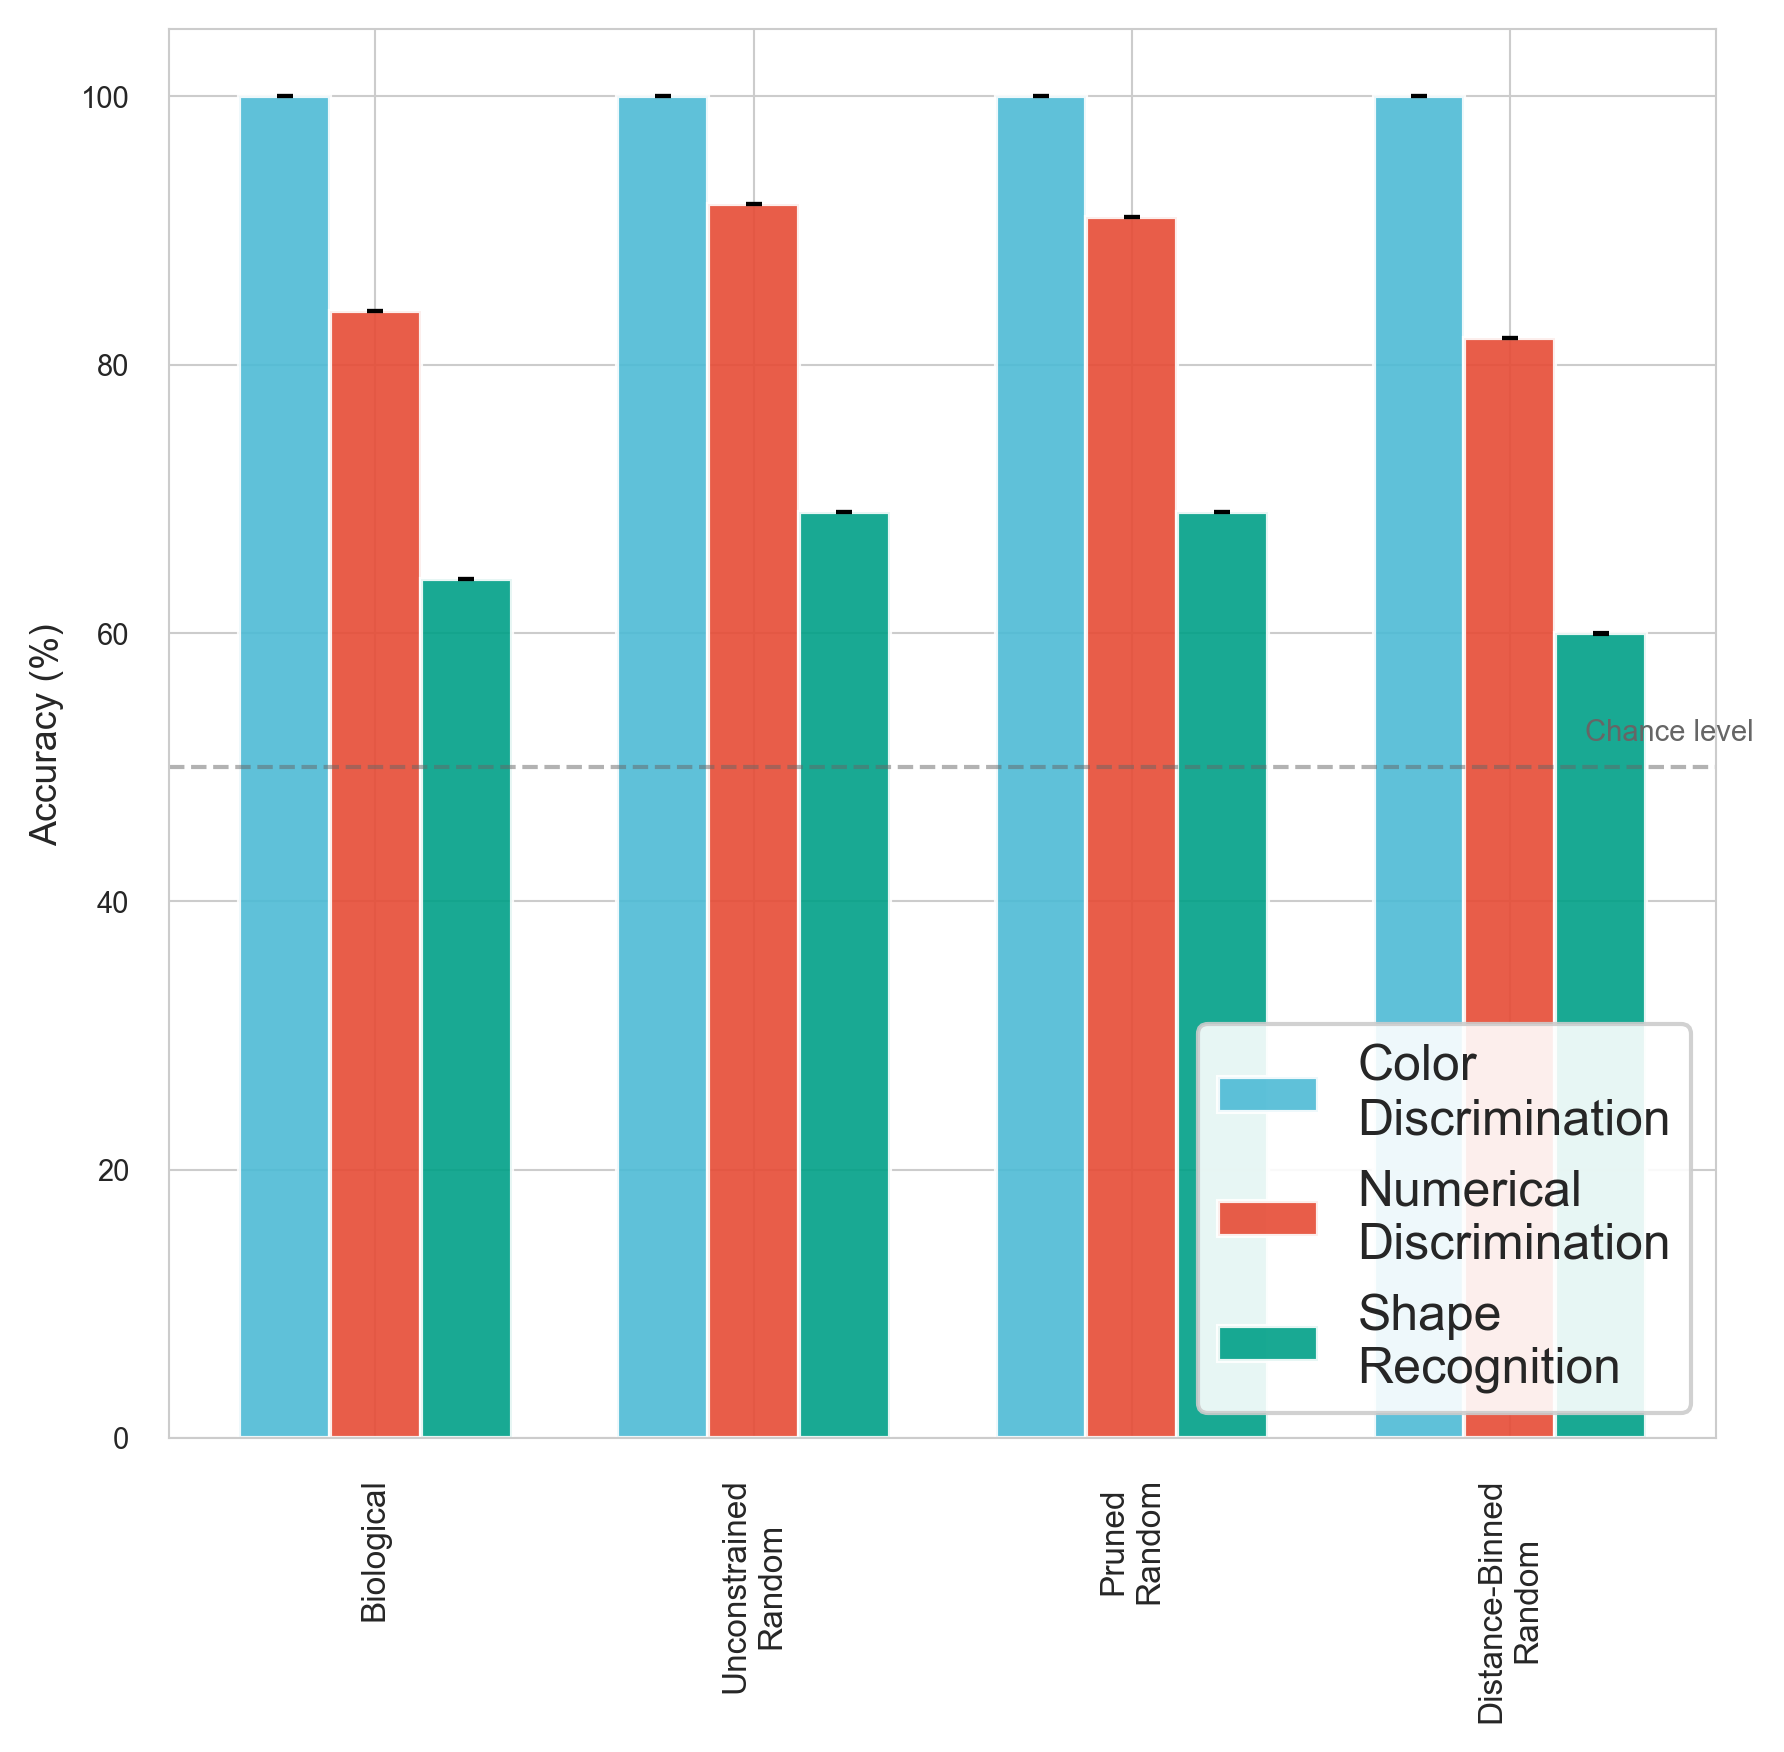

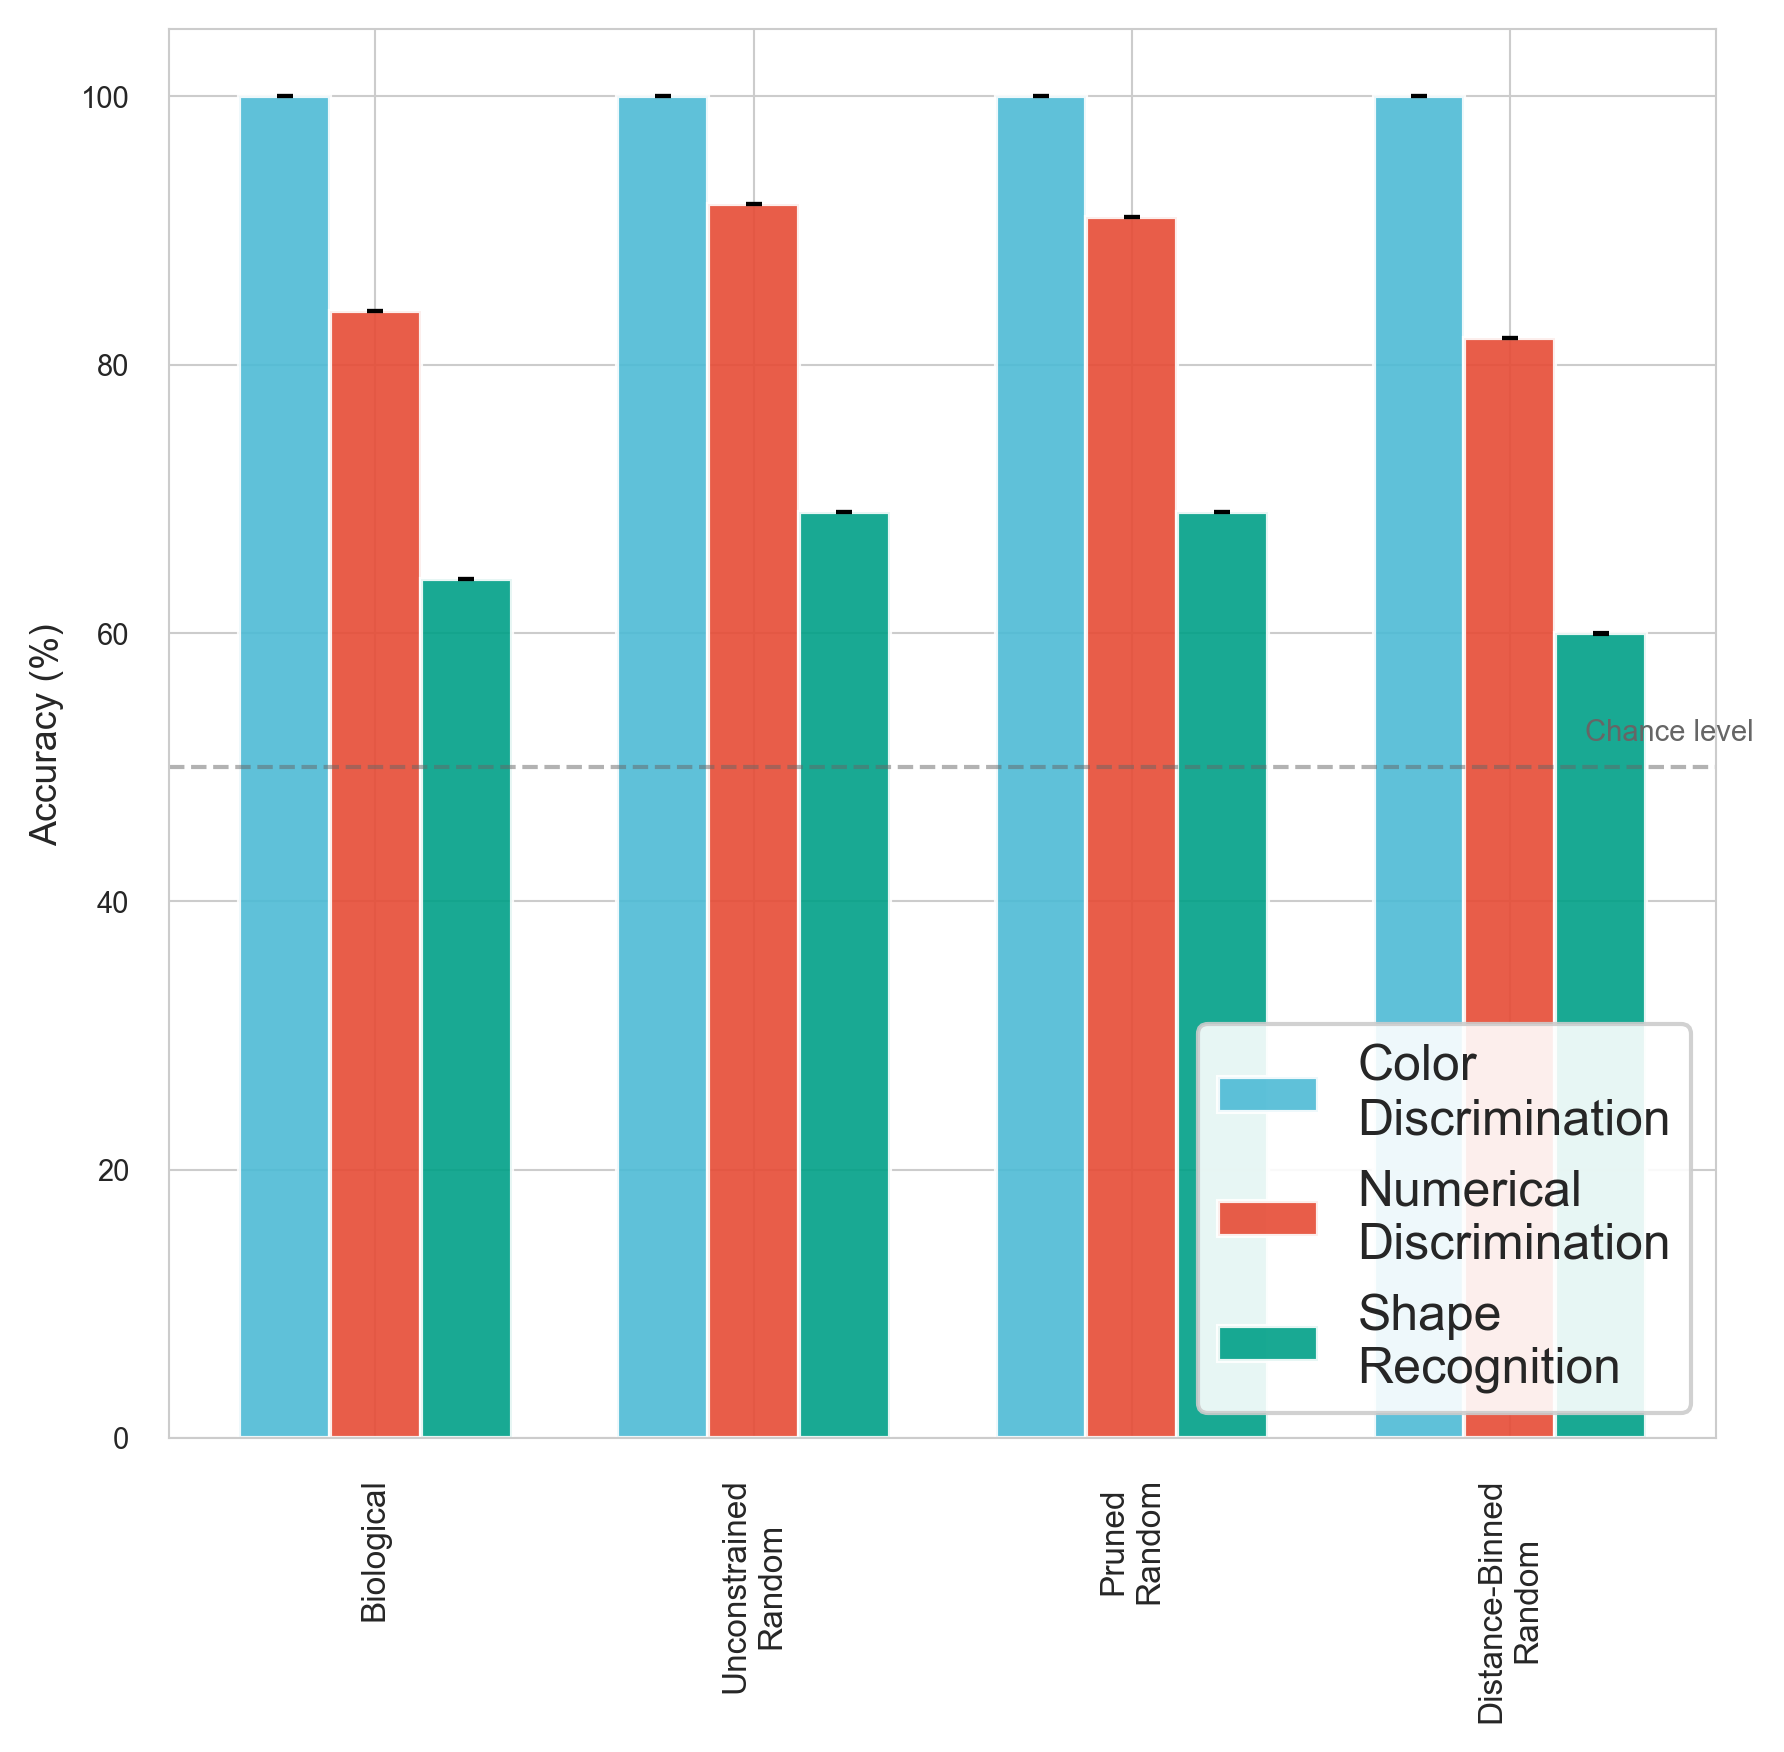

In [14]:
def panel_c():
    # Network configurations
    networks = [
        "Biological",
        "Unconstrained\nRandom",
        "Pruned\nRandom",
        "Distance-Binned\nRandom",
    ]

    # Made-up performance data for three tasks (percentage accuracy)
    numerical_task = [84, 92, 91, 82] 
    color_task = [100, 100, 100, 100] 
    shape_task = [64, 69, 69, 60] 

    # Made-up error bars (standard error)
    numerical_err = [0, 0, 0, 0.01]
    color_err = [0, 0, 0, 0]
    shape_err = [0, 0.01, 0, 0.04]

    # Nature color palette (starts with red and blue)
    colors = ["#E64B35", "#4DBBD5", "#00A087"]

    # Set width of bars
    bar_width = 0.24
    capsize = 2
    index = np.arange(len(networks))

    # Create the figure with Nature-compatible dimensions
    fig3, ax = plt.subplots(figsize=(6, 6), dpi=300)

    # Create grouped bars in the requested order with error bars

    bars = ax.bar(
        index - bar_width,
        color_task,
        bar_width,
        yerr=color_err,
        label="Color\nDiscrimination",
        color=colors[1],
        alpha=0.9,
        capsize=capsize,
        ecolor="black",
        error_kw={"elinewidth": 1},
    )

    bars = ax.bar(
        index,
        numerical_task,
        bar_width,
        yerr=numerical_err,
        label="Numerical\nDiscrimination",
        color=colors[0],
        alpha=0.9,
        capsize=capsize,
        ecolor="black",
        error_kw={"elinewidth": 1},
    )
    bars = ax.bar(
        index + bar_width,
        shape_task,
        bar_width,
        yerr=shape_err,
        label="Shape\nRecognition",
        color=colors[2],
        alpha=0.9,
        capsize=capsize,
        ecolor="black",
        error_kw={"elinewidth": 1},
    )

    # Add horizontal line for chance level (50% for binary classification)
    ax.axhline(y=50, linestyle="--", color="#666666", alpha=0.5, linewidth=1)

    # Add text label for chance level
    ax.text(len(networks) - 0.8, 52, "Chance level", fontsize=7, color="#666666")

    # Add labels and custom x-axis tick labels
    ax.set_ylabel("Accuracy (%)", fontsize=9)
    ax.set_ylim(0, 105)  # Slightly higher to accommodate error bars
    ax.set_xticks(index)
    ax.set_xticklabels(networks, fontsize=8, rotation=90)  # Vertical labels

    # Add a legend
    ax.legend(fontsize=12, loc="lower right", framealpha=0.9)

    # Adjust layout with extra bottom margin for vertical labels
    plt.tight_layout()
    fig3.subplots_adjust(bottom=0.2)  # Make room for vertical labels

    # Save figure with transparent background (Nature preference)
    plt.savefig(os.path.join(plots_dir, "figure2_panel_c.png"), dpi=300, bbox_inches="tight", transparent=True)
    plt.savefig(os.path.join(plots_dir, "figure2_panel_c.pdf"), bbox_inches="tight") 
    #plt.show()

    return fig3

panel_c()

# Panel d

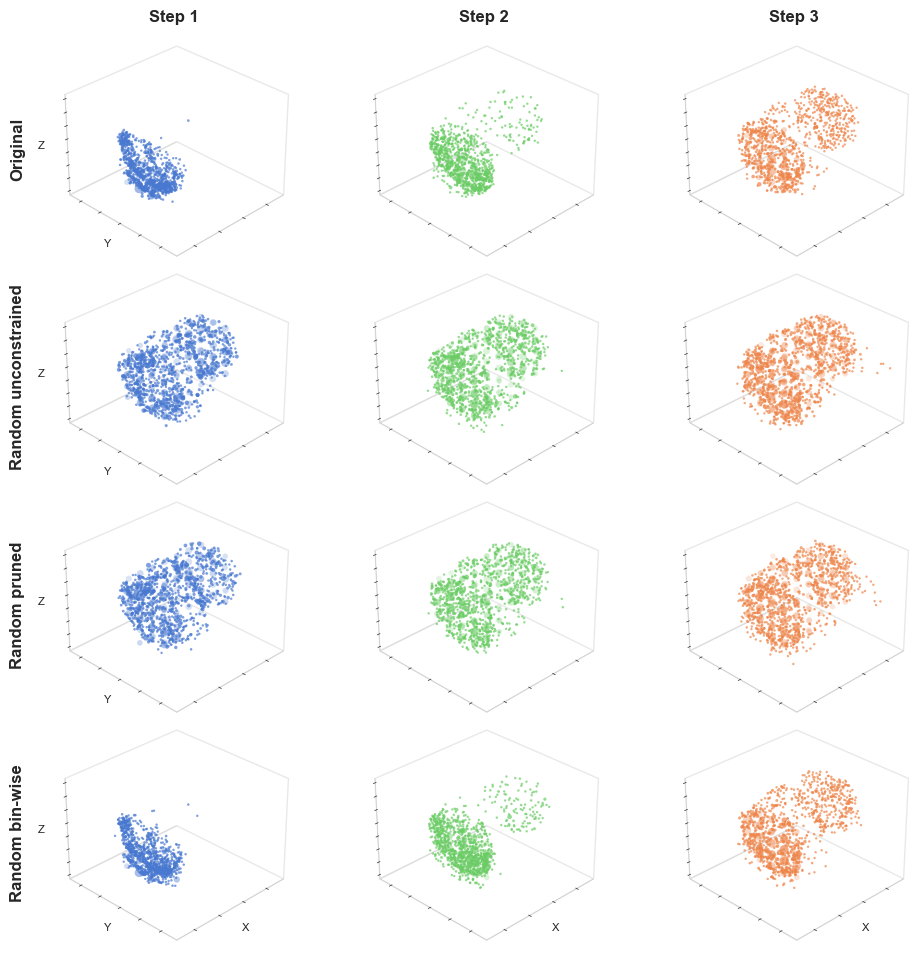

In [19]:
import importlib
from notebooks.visualization import activation_plots
importlib.reload(activation_plots)
from notebooks.visualization.activation_plots import visualize_steps_separated_compact

fig4 = visualize_steps_separated_compact(
    configurations,
    neuron_position_data,
    num_steps=3,
    max_neurons_per_step=1000,
    voxel_size=10,
    smoothing=0.5,
    padding_percent=5,
    figsize=(18, 12),
)

# Save figure with transparent background (Nature preference)
plt.savefig(os.path.join(plots_dir, "figure2_panel_d.png"), dpi=300, bbox_inches="tight", transparent=True)
plt.savefig(os.path.join(plots_dir, "figure2_panel_d.pdf"), bbox_inches="tight") 
plt.show()

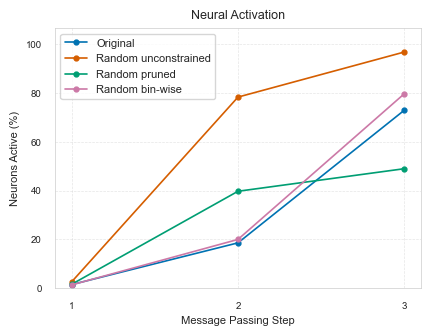

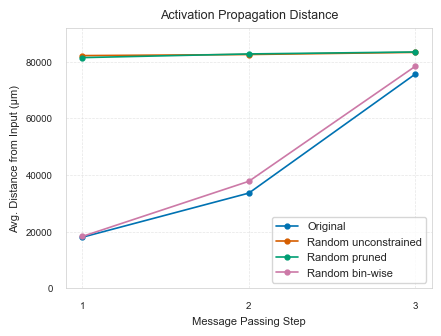

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl


def plot_activation_statistics_nature(
    propagations_dict, neuron_position_data, num_steps=4, fig_width=120
):
    """
    Plot statistics about neuronal activations across different configurations in Nature journal style.

    Parameters:
    -----------
    propagations_dict : dict
        Dictionary of DataFrames with activation data for different configurations
    neuron_position_data : DataFrame
        DataFrame containing position data for neurons
    fig_width : int
        Width in mm (183mm for double-column in Nature)

    Returns:
    --------
    tuple
        Two matplotlib.figure.Figure objects: one for activation percentages and one for activation distances.
    """
    # Set Nature style parameters
    mpl.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 7,
            "axes.labelsize": 8,
            "axes.titlesize": 9,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.0,
            "lines.markersize": 3,
        }
    )

    # Nature-friendly color scheme
    colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7", "#56B4E9", "#E69F00"]

    # Calculate metrics for each configuration
    configs = list(propagations_dict.keys())
    activation_percentages = {config: [] for config in configs}
    activation_distances = {config: [] for config in configs}

    for config, prop_df in propagations_dict.items():
        # Calculate percentage of neurons active at each step
        total_neurons = len(neuron_position_data)

        for step in range(1, num_steps + 1):
            act_col = f"activation_{step}"
            if act_col in prop_df.columns:
                active_neurons = prop_df[prop_df[act_col] > 0]["root_id"].nunique()
                activation_percentages[config].append(
                    100 * active_neurons / total_neurons
                )
            else:
                activation_percentages[config].append(0)

        # Merge prop_df with neuron_position_data to get positions
        merged = pd.merge(prop_df, neuron_position_data, on="root_id")

        # Calculate average distance of active neurons from eye
        input_active = merged[merged["input"] > 0]
        if not input_active.empty:
            eye_position = input_active[["pos_x", "pos_y", "pos_z"]].mean().values
        else:
            raise ValueError(
                f"No neurons are activated in the 'input' column for config {config}."
            )

        for step in range(1, num_steps + 1):
            act_col = f"activation_{step}"
            if act_col in merged.columns:
                active = merged[merged[act_col] > 0]
                if len(active) > 0:
                    positions = active[["pos_x", "pos_y", "pos_z"]].values
                    distances = np.sqrt(np.sum((positions - eye_position) ** 2, axis=1))
                    activation_distances[config].append(np.mean(distances))
                else:
                    activation_distances[config].append(0)
            else:
                activation_distances[config].append(0)

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701
    fig_height_in = fig_width_in / 1.4

    # Create figure for activation percentages
    fig1, ax1 = plt.subplots(figsize=(fig_width_in, fig_height_in))
    for i, config in enumerate(configs):
        ax1.plot(
            range(1, num_steps + 1),
            activation_percentages[config],
            marker="o",
            label=config,
            color=colors[i % len(colors)],
            linewidth=1.2,
            markersize=3.5,
        )

    ax1.set_xlabel("Message Passing Step")
    ax1.set_ylabel("Neurons Active (%)")
    ax1.set_title("Neural Activation", pad=7)
    ax1.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)
    ax1.set_xticks(range(1, num_steps + 1))
    ymax1 = max([max(vals) for vals in activation_percentages.values()]) * 1.1
    ax1.set_ylim(0, ymax1)
    ax1.legend(loc="upper left", fontsize=8)

    # Create figure for activation distances
    fig2, ax2 = plt.subplots(figsize=(fig_width_in, fig_height_in))
    for i, config in enumerate(configs):
        ax2.plot(
            range(1, num_steps + 1),
            activation_distances[config],
            marker="o",
            label=config,
            color=colors[i % len(colors)],
            linewidth=1.2,
            markersize=3.5,
        )

    ax2.set_xlabel("Message Passing Step")
    ax2.set_ylabel("Avg. Distance from Input (μm)")
    ax2.set_title("Activation Propagation Distance", pad=7)
    ax2.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)
    ax2.set_xticks(range(1, num_steps + 1))
    ymax2 = max([max(vals) for vals in activation_distances.values()]) * 1.1
    ax2.set_ylim(0, ymax2)
    ax2.legend(loc="lower right", fontsize=8)

    return fig1, fig2


fig5, fig6 = plot_activation_statistics_nature(configurations, neuron_position_data, num_steps=3)
# save them
fig5.savefig(os.path.join(plots_dir, "figure2_panel_e.png"), dpi=300, bbox_inches="tight")
fig5.savefig(os.path.join(plots_dir, "figure2_panel_e.pdf"), bbox_inches="tight")
fig6.savefig(os.path.join(plots_dir, "figure2_panel_f.png"), dpi=300, bbox_inches="tight")
fig6.savefig(os.path.join(plots_dir, "figure2_panel_f.pdf"), bbox_inches="tight")
plt.show()

# All together

NameError: name 'fig1' is not defined

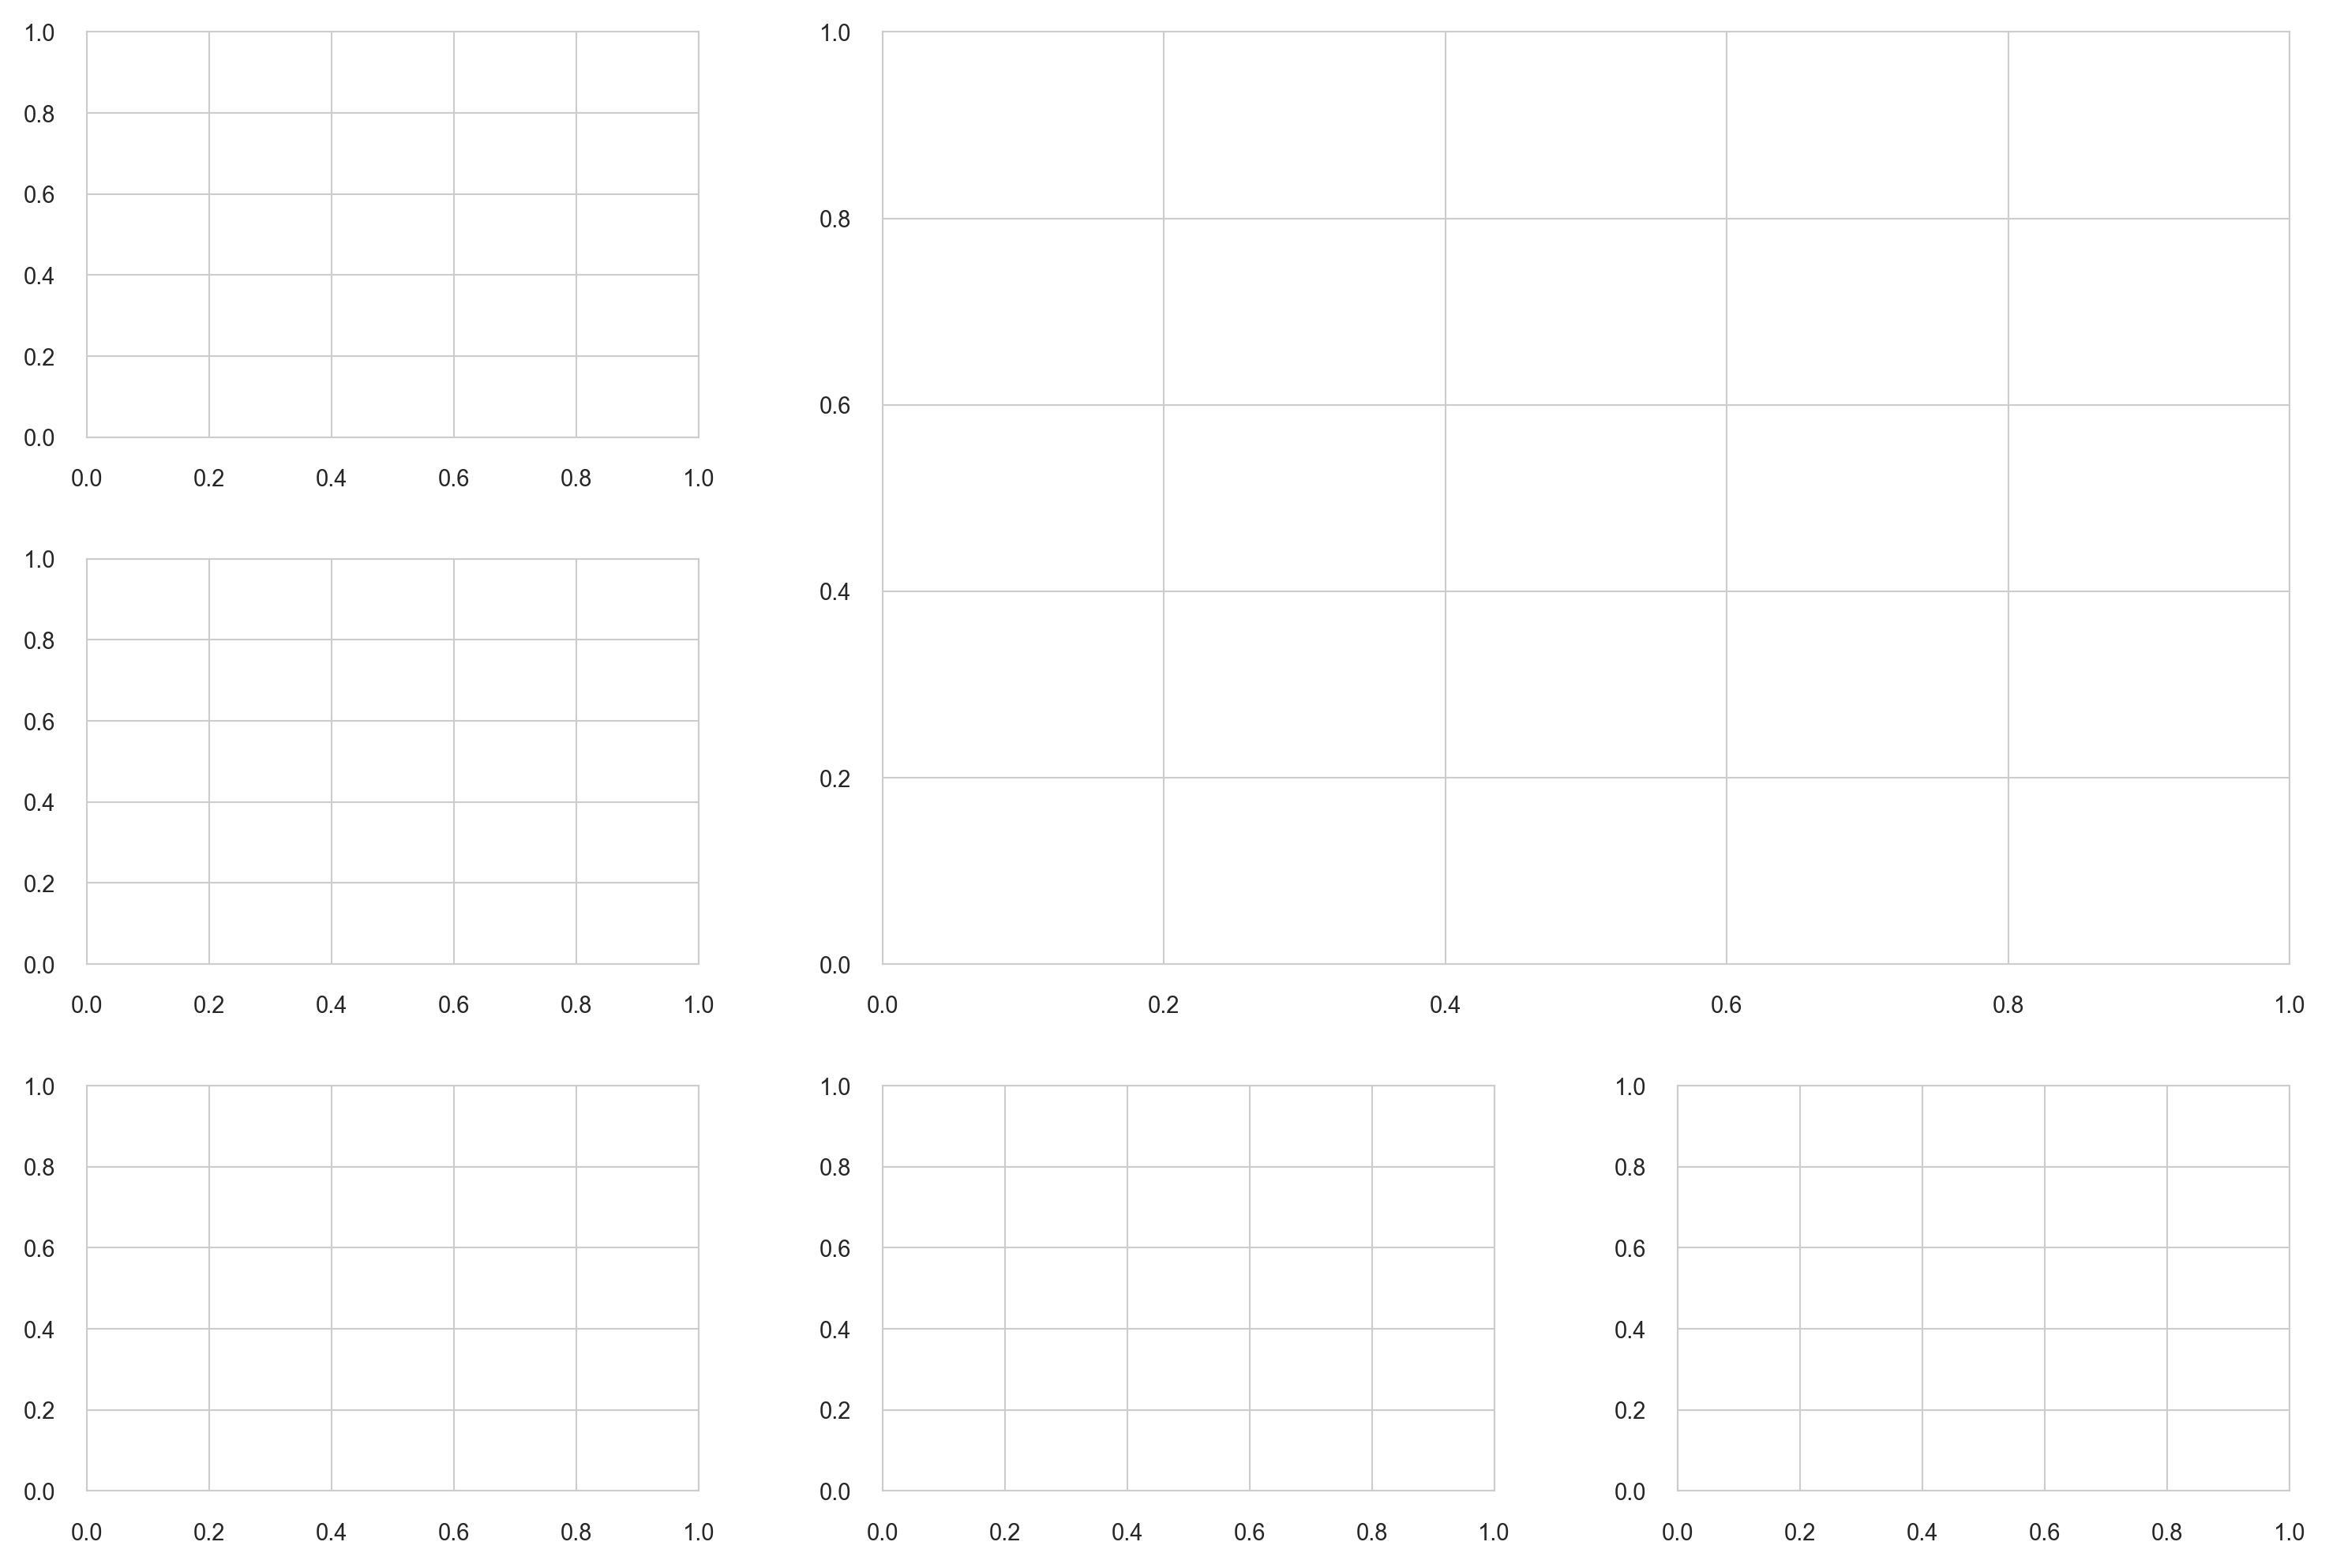

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import copy
import os
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Create a new composite figure
fig = plt.figure(figsize=(12, 8), dpi=300)  # Adjusted size for the new layout

# Create a custom grid - 3 rows, 3 columns
gs = GridSpec(3, 3, figure=fig, wspace=0.3, hspace=0.3)  # Adjusted spacing


def fig2data(fig):
    """
    Convert a Matplotlib figure to a numpy array with RGBA channels
    """
    # Draw the renderer
    canvas = FigureCanvasAgg(fig)
    canvas.draw()

    # Get the RGBA buffer from the figure
    w, h = canvas.get_width_height()
    buf = np.frombuffer(canvas.buffer_rgba(), dtype=np.uint8)
    buf.shape = (h, w, 4)
    return buf


def transfer_figure_to_axes(source_fig, target_axes):
    """
    Transfer content from one figure to a subplot in another figure with proper scaling
    """
    # Convert the source figure to an image array
    img_data = fig2data(source_fig)

    # Clear previous content
    target_axes.clear()

    # Display the image scaled to fill the axes
    img = target_axes.imshow(img_data, aspect="auto")

    # Remove axes ticks and spines for clean display
    target_axes.set_xticks([])
    target_axes.set_yticks([])
    for spine in target_axes.spines.values():
        spine.set_visible(False)


# Create subplots for the new layout
ax1 = fig.add_subplot(gs[0, 0])  # Plot a - top left
ax2 = fig.add_subplot(gs[:2, 1:])  # Plot b - 2x2 grid top right
ax3 = fig.add_subplot(gs[1, 0])  # Plot c - middle left

ax4 = fig.add_subplot(gs[2, 0])  # Plot d - bottom left
ax5 = fig.add_subplot(gs[2, 1])  # Plot e - bottom middle
ax6 = fig.add_subplot(gs[2, 2])  # Plot f - bottom right

# Transfer each figure to its respective subplot
transfer_figure_to_axes(fig1, ax1)  # a
transfer_figure_to_axes(fig4, ax2)  # b (spans 2x2 grid)
transfer_figure_to_axes(fig5, ax3)  # c

transfer_figure_to_axes(fig6, ax4)  # d
transfer_figure_to_axes(fig2, ax5)  # e
transfer_figure_to_axes(fig3, ax6)  # f

# Add panel labels
x_off = -0.05
y_off = 1.05
ax1.text(x_off, y_off, "a", transform=ax1.transAxes, fontsize=16, fontweight="bold")
ax2.text(x_off, y_off, "b", transform=ax2.transAxes, fontsize=16, fontweight="bold")
ax3.text(x_off, y_off, "b", transform=ax3.transAxes, fontsize=16, fontweight="bold")
ax4.text(x_off, y_off, "d", transform=ax4.transAxes, fontsize=16, fontweight="bold")
ax5.text(x_off, y_off, "c", transform=ax5.transAxes, fontsize=16, fontweight="bold")
ax6.text(x_off, y_off, "f", transform=ax6.transAxes, fontsize=16, fontweight="bold")

fig.tight_layout()

plt.savefig(
    os.path.join(plots_dir, "network_configs_panel_updated.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(plots_dir, "network_configs_panel_updated.pdf"), bbox_inches="tight"
)

plt.show()

/tmp/ipykernel_26187/1870348538.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


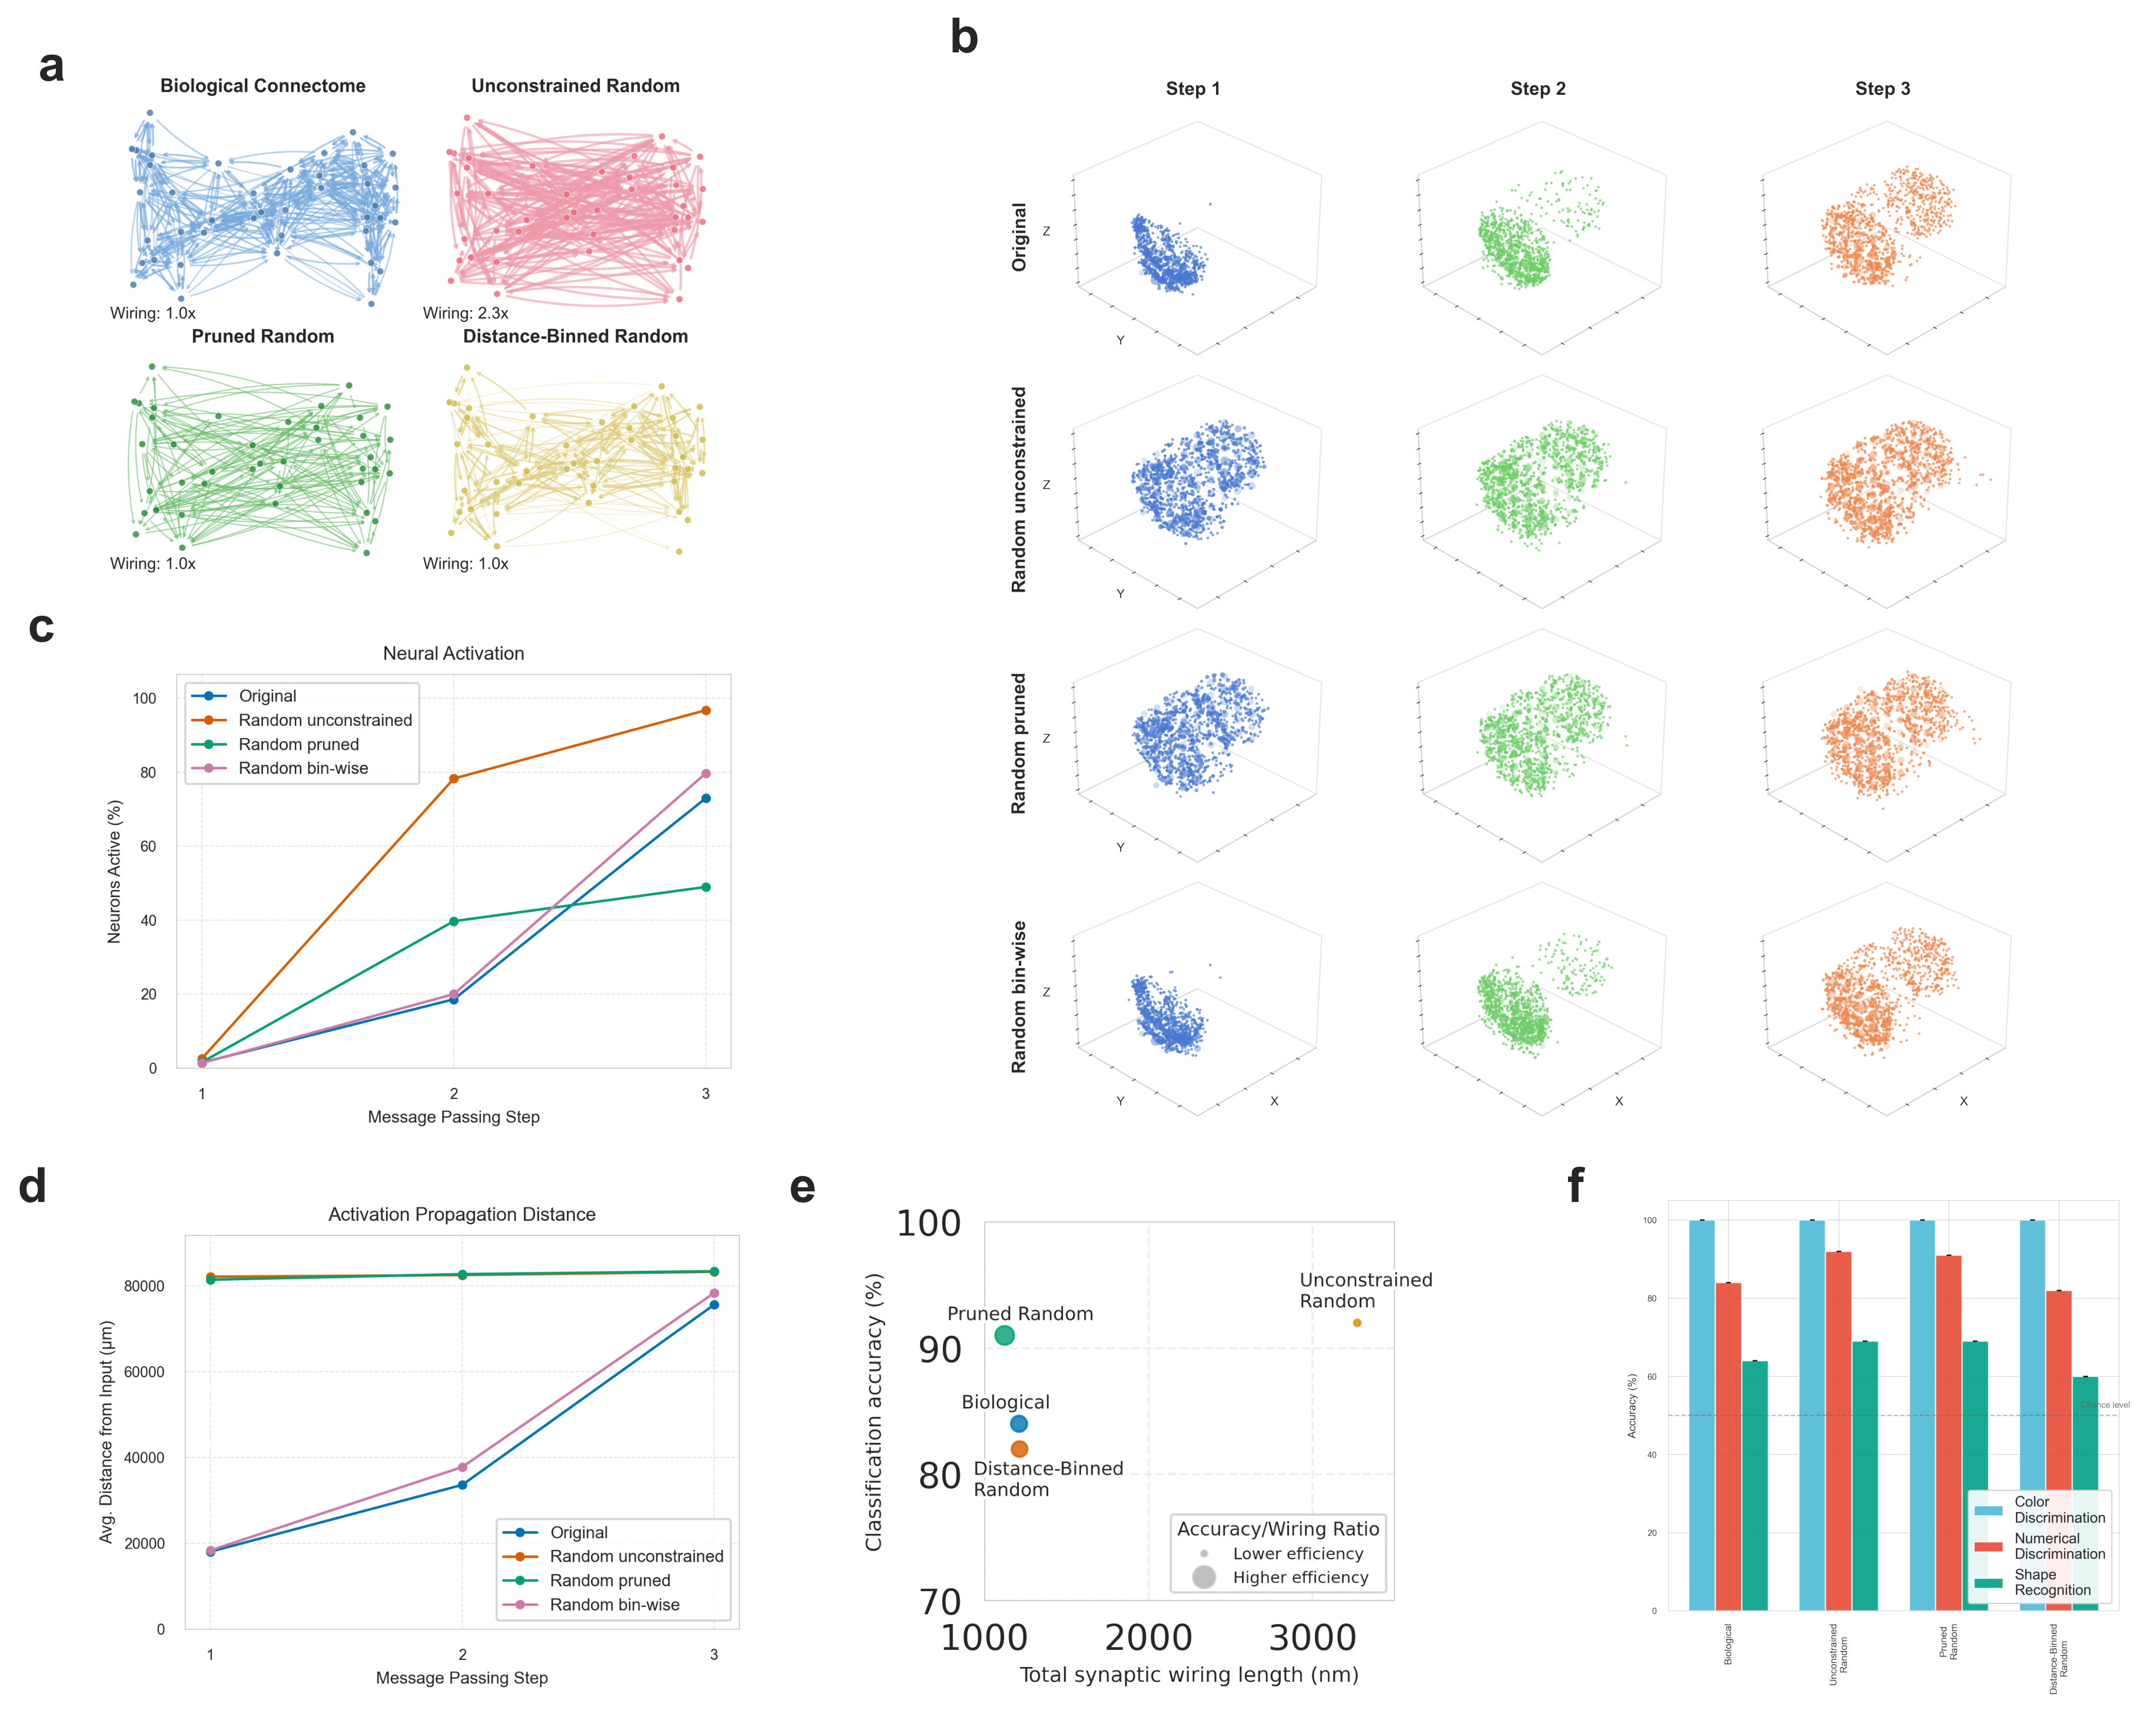

In [20]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
import os

# Do this for each panel...

# Create the composite figure
fig = plt.figure(figsize=(16, 12), dpi=300)
gs = GridSpec(3, 3, figure=fig, wspace=0., hspace=0.1)

# Define subplot areas
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[:2, 1:])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])
ax6 = fig.add_subplot(gs[2, 2])

# Load the images
dir_path = os.path.join(PROJECT_ROOT, "plots")
ax1.imshow(mpimg.imread(os.path.join(dir_path, "figure2a_network_configs.png")))
ax2.imshow(mpimg.imread(os.path.join(dir_path, "figure2_panel_d.png")))
ax3.imshow(mpimg.imread(os.path.join(dir_path, "figure2_panel_e.png")))
ax4.imshow(mpimg.imread(os.path.join(dir_path, "figure2_panel_f.png")))
ax5.imshow(mpimg.imread(os.path.join(dir_path, "figure2_panel_b.png")))
ax6.imshow(mpimg.imread(os.path.join(dir_path, "figure2_panel_c.png")))

for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.axis("off")

# Add panel labels with improved positioning
label_params = {"fontsize": 20, "fontweight": "bold", "va": "top", "ha": "left"}

ax1.text(-0.1, 1.05, "a", transform=ax1.transAxes, **label_params)
ax2.text(-0.05, 1.05, "b", transform=ax2.transAxes, **label_params)
ax3.text(-0.1, 1.05, "c", transform=ax3.transAxes, **label_params)
ax4.text(-0.1, 1.05, "d", transform=ax4.transAxes, **label_params)
ax5.text(-0.1, 1.05, "e", transform=ax5.transAxes, **label_params)
ax6.text(-0.1, 1.05, "f", transform=ax6.transAxes, **label_params)

plt.tight_layout()

# save
plt.savefig(
    os.path.join(plots_dir, "figure2_panel_updated.png"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(plots_dir, "figure2_panel_updated.pdf"), bbox_inches="tight"
)

plt.show()

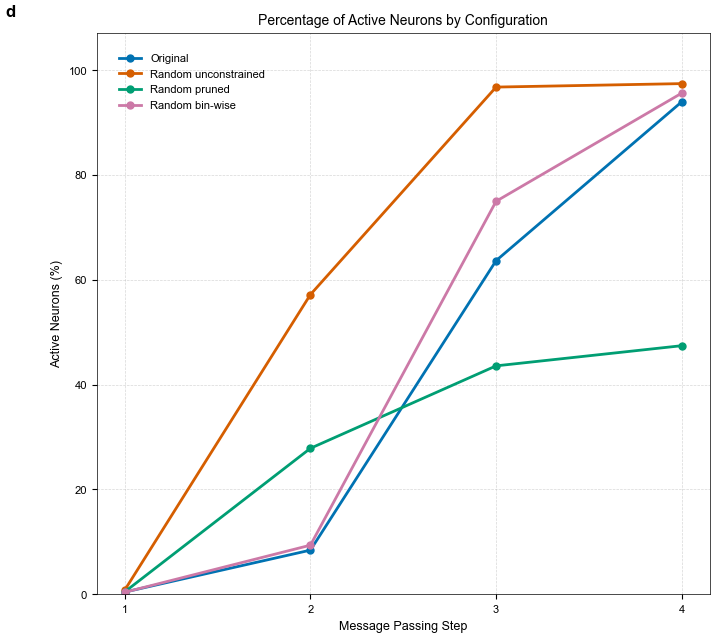

In [5]:
import matplotlib.pyplot as plt
import pandas as pd


def create_active_neurons_plot(
    propagation_dict, colors=None, fig_width=89, dpi=600, activation_threshold=0
):
    """
    Create a Nature-style plot showing percentage of active neurons
    across different connectome configurations.

    Parameters:
    -----------
    propagation_dict : dict
        Dictionary of DataFrames for different connectome configurations
    colors : list of str, optional
        Colors for each configuration
    fig_width : int
        Width in mm (Nature single column is 89mm, double column is 183mm)
    dpi : int
        Resolution (Nature requires at least 300 dpi)
    activation_threshold : float
        Threshold for considering a neuron active

    Returns:
    --------
    matplotlib.figure.Figure
        A Nature-style figure with active neurons plot
    """
    # Set Nature style
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 8,
            "axes.labelsize": 9,
            "axes.titlesize": 10,
            "xtick.labelsize": 8,
            "ytick.labelsize": 8,
            "legend.fontsize": 8,
            "figure.titlesize": 10,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.5,
            "lines.markersize": 4,
            "savefig.dpi": dpi,
            "savefig.format": "tiff",
            "savefig.bbox": "tight",
            "savefig.pad_inches": 0.05,
        }
    )

    # Default Nature-friendly colors if not provided
    if colors is None:
        colors = ["#0072B2", "#D55E00", "#009E73", "#CC79A7"]

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701

    # Figure height
    fig_height_in = fig_width_in * 0.9  # Slightly less than square for single plot

    # Create figure
    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in))

    # Calculate activation metrics for each configuration
    all_metrics = []

    for label, prop_df in propagation_dict.items():
        metrics = []

        # Calculate metrics for each activation step
        for step in range(1, 5):
            activation_col = f"activation_{step}"

            # Skip if column doesn't exist
            if activation_col not in prop_df.columns:
                continue

            # Count active neurons
            active_neurons = prop_df[prop_df[activation_col] > activation_threshold]
            active_count = len(active_neurons)
            total_count = len(prop_df)

            # Calculate percentage of active neurons
            percent_active = (
                (active_count / total_count) * 100 if total_count > 0 else 0
            )

            # Store metrics
            metrics.append(
                {
                    "Step": step,
                    "Active Neurons (%)": percent_active,
                }
            )

        # Add to overall metrics with configuration label
        metrics_df = pd.DataFrame(metrics)
        metrics_df["Configuration"] = label
        all_metrics.append(metrics_df)

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    # Plot each configuration
    for j, config in enumerate(propagation_dict.keys()):
        config_data = combined_metrics[combined_metrics["Configuration"] == config]

        # Plot line
        ax.plot(
            config_data["Step"],
            config_data["Active Neurons (%)"],
            marker="o",
            label=config,
            color=colors[j % len(colors)],
            linewidth=2,
            markersize=5,
        )

    # Set labels and title
    ax.set_xlabel("Message Passing Step")
    ax.set_ylabel("Active Neurons (%)")
    ax.set_title("Percentage of Active Neurons by Configuration")

    # Set x-axis ticks to integers
    ax.set_xticks(range(1, 5))

    # Set y-axis range from 0 to appropriate max with some padding
    y_max = combined_metrics["Active Neurons (%)"].max() * 1.1
    ax.set_ylim(0, y_max)

    # Add grid
    ax.grid(True, linestyle="--", alpha=0.5, linewidth=0.5)

    # Add legend with improved positioning
    ax.legend(frameon=False, loc="upper left", bbox_to_anchor=(0.02, 0.98), ncol=1)

    # Add letter label for panel identification in Nature paper
    ax.text(
        -0.15,
        1.05,
        "d",
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        va="top",
    )

    # Set tight layout
    plt.tight_layout()

    return fig


# Example usage:
# fig = create_active_neurons_plot(configurations, fig_width=89, dpi=600, activation_threshold=0.1)
# plt.savefig("Figure3d_active_neurons.tif", dpi=600)
# plt.savefig("Figure3d_active_neurons.pdf", dpi=600)
# plt.close()

# Create the figure
fig = create_active_neurons_plot(
    configurations, fig_width=183, dpi=300, activation_threshold=0.1
)
plt.show()

In [6]:
aa = configurations["Original"]

In [8]:
# find percentage of non-zero values per step
for step in range(1, 5):
    print(f"Step {step}: {len(aa[aa[f'activation_{step}'] > 0]) / len(aa) * 100:.2f}%")

Step 1: 0.67%
Step 2: 10.54%
Step 3: 66.95%
Step 4: 94.01%


/tmp/ipykernel_26187/473524615.py:12: DtypeWarning: Columns (14,15,16,17,23) have mixed types. Specify dtype option on import or set low_memory=False.
  neurons = pd.read_csv(os.path.join(data_dir, "neuron_annotations.tsv"), sep="\t")
/tmp/ipykernel_26187/473524615.py:24: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  neuron_coords["soma_x"].fillna(neuron_coords["pos_x"], inplace=True)
/tmp/ipykernel_26187/473524615.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment u

Original connections: 16847997, Random connections: 16847997
Original synapses: 54492922, Random synapses: 20796123

Distance statistics (sample size: 16847997 original, 16847997 random):
Original mean distance: 24914.41, median: 20675.24
Random mean distance: 63632.66, median: 57818.32
Original total wiring: 1401194004800.10
Random total wiring: 1387246884134.31
Wiring ratio (random/original): 0.9900


/tmp/ipykernel_26187/473524615.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels)


Text(0.5, 1.0, 'Distance Distribution')

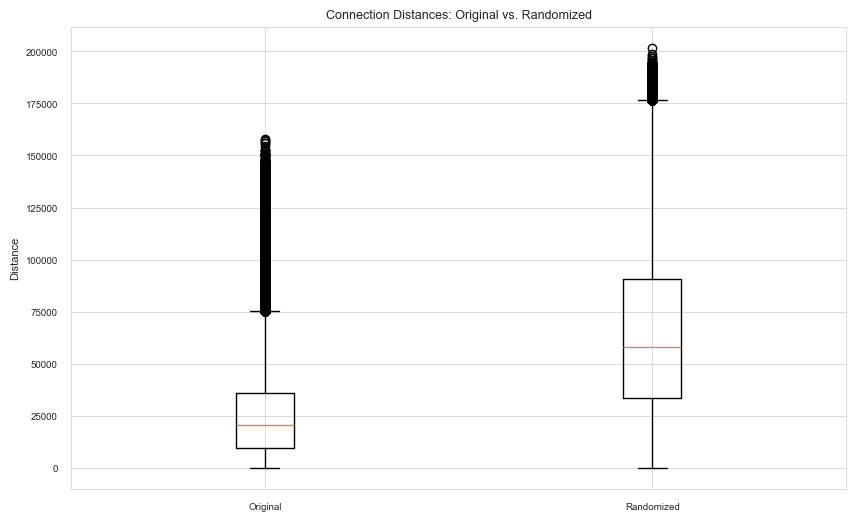

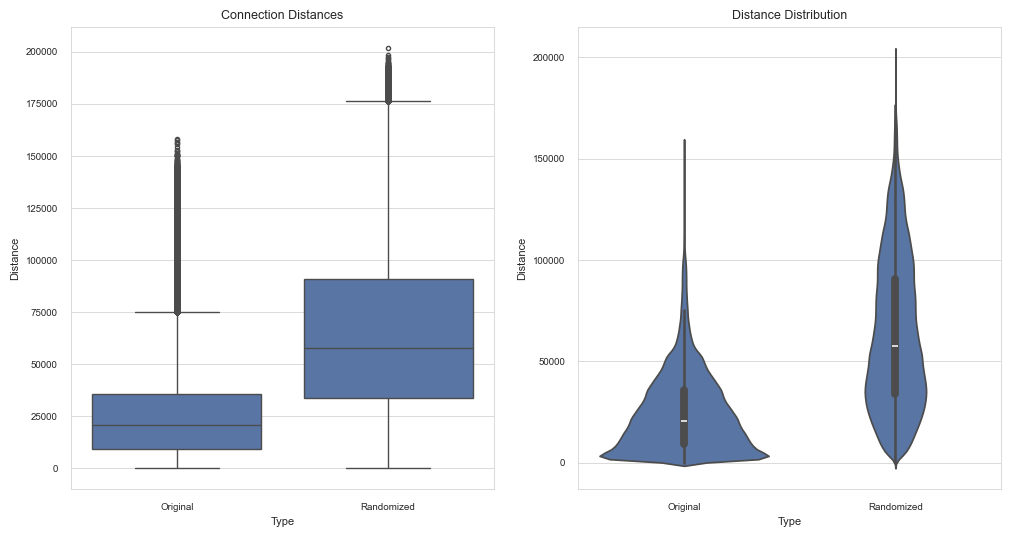

In [23]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from paths import PROJECT_ROOT

data_dir = os.path.join(PROJECT_ROOT, "new_data")
# Load data
connections = pd.read_csv(os.path.join(data_dir, "connections.csv"))
connections_random = pd.read_csv(os.path.join(data_dir, "connections_random_pruned.csv"))
neurons = pd.read_csv(os.path.join(data_dir, "neuron_annotations.tsv"), sep="\t")

# Basic stats
print(
    f"Original connections: {len(connections)}, Random connections: {len(connections_random)}"
)
print(
    f"Original synapses: {connections['syn_count'].sum()}, Random synapses: {connections_random['syn_count'].sum()}"
)

# Prepare neuron coordinates
neuron_coords = neurons.copy()
neuron_coords["soma_x"].fillna(neuron_coords["pos_x"], inplace=True)
neuron_coords["soma_y"].fillna(neuron_coords["pos_y"], inplace=True)
neuron_coords["soma_z"].fillna(neuron_coords["pos_z"], inplace=True)
neuron_coords = neuron_coords[["root_id", "soma_x", "soma_y", "soma_z"]].set_index(
    "root_id"
)


# Function to add coordinates to connections
def add_coords(connections_df, coords_df):
    # Add pre-neuron coordinates
    df = connections_df.merge(
        coords_df,
        left_on="pre_root_id",
        right_index=True,
        how="left",
        suffixes=("", "_pre"),
    )

    # Add post-neuron coordinates
    df = df.merge(
        coords_df,
        left_on="post_root_id",
        right_index=True,
        how="left",
        suffixes=("", "_post"),
    )

    # Rename columns for clarity
    df = df.rename(
        columns={
            "soma_x": "pre_x",
            "soma_y": "pre_y",
            "soma_z": "pre_z",
            "soma_x_post": "post_x",
            "soma_y_post": "post_y",
            "soma_z_post": "post_z",
        }
    )

    return df

# Add coordinates to both samples
orig_with_coords = add_coords(connections, neuron_coords)
random_with_coords = add_coords(connections_random, neuron_coords)


# Calculate distances in a vectorized way
def calculate_distances(df):
    # Get coordinate arrays
    pre_coords = df[["pre_x", "pre_y", "pre_z"]].to_numpy()
    post_coords = df[["post_x", "post_y", "post_z"]].to_numpy()

    # Calculate distances
    distances = np.linalg.norm(pre_coords - post_coords, axis=1)

    # Calculate wiring length (distance * synapse count)
    wiring_length = distances * df["syn_count"].to_numpy()

    return distances, wiring_length


# Calculate distances for both datasets
orig_distances, orig_wiring = calculate_distances(orig_with_coords)
random_distances, random_wiring = calculate_distances(random_with_coords)

# Print summary statistics
print(
    f"\nDistance statistics (sample size: {len(orig_distances)} original, {len(random_distances)} random):"
)
print(
    f"Original mean distance: {np.mean(orig_distances):.2f}, median: {np.median(orig_distances):.2f}"
)
print(
    f"Random mean distance: {np.mean(random_distances):.2f}, median: {np.median(random_distances):.2f}"
)
print(f"Original total wiring: {np.sum(orig_wiring):.2f}")
print(f"Random total wiring: {np.sum(random_wiring):.2f}")
print(
    f"Wiring ratio (random/original): {np.sum(random_wiring)/np.sum(orig_wiring):.4f}"
)

# Create a boxplot comparing the distributions
plt.figure(figsize=(10, 6))
data = [orig_distances, random_distances]
labels = ["Original", "Randomized"]

plt.boxplot(data, labels=labels)
plt.ylabel("Distance")
plt.title("Connection Distances: Original vs. Randomized")
plt.savefig("distance_boxplot.png")

# Create a more detailed plot with seaborn
plt.figure(figsize=(12, 6))
df_combined = pd.DataFrame(
    {
        "Distance": np.concatenate([orig_distances, random_distances]),
        "Type": ["Original"] * len(orig_distances)
        + ["Randomized"] * len(random_distances),
    }
)

# Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(x="Type", y="Distance", data=df_combined)
plt.title("Connection Distances")

# Violin plot (shows distribution better)
plt.subplot(1, 2, 2)
sns.violinplot(x="Type", y="Distance", data=df_combined)
plt.title("Distance Distribution")